## 제로 쿠폰 채권 평가

In [21]:
def zero_coupon_bond(par, y, t):
    """
    제로쿠폰 채권의 현재가치를 계산하는 함수
    
    매개변수:
    par: 채권의 액면가 (원금)
    y: 연간 수익률 (이자율)
    t: 만기까지 남은 기간 (연 단위)
    
    반환값:
    현재가치 (Present Value)
    """
    return par/(1+y)**t

# 예시: 액면가 100원, 수익률 5%, 만기 5년인 제로쿠폰 채권의 현재가치 계산
print(zero_coupon_bond(100, 0.05, 5))

78.35261664684589


## 수익률 곡선 부트스트랩 클래스 작성

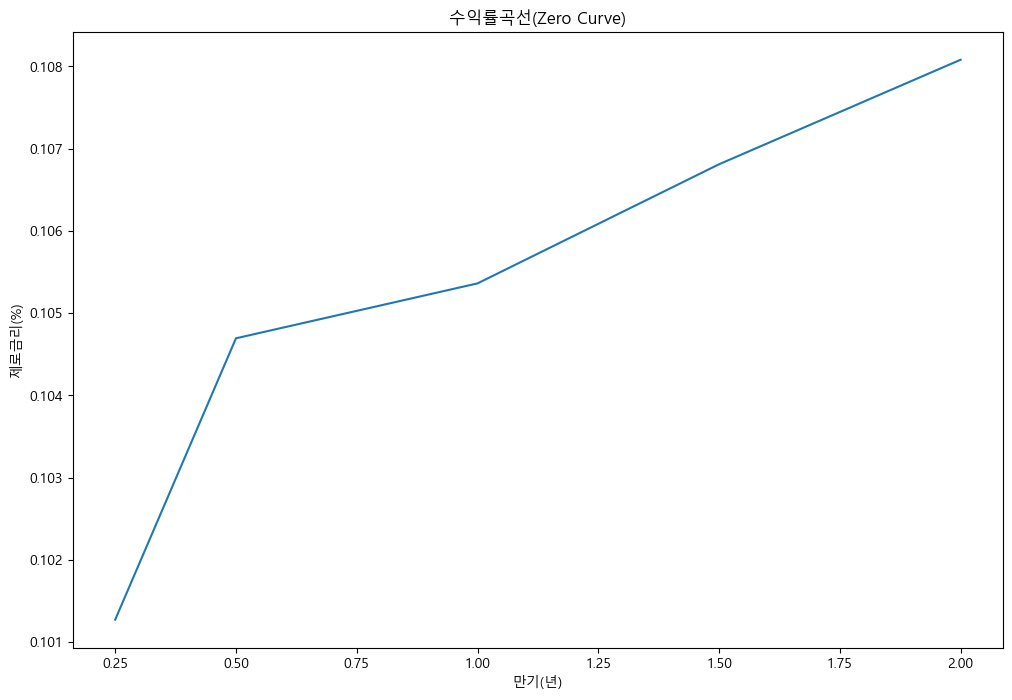

In [22]:
import math
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'     # 윈도우의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False        # 마이너스 기호 깨짐 방지

class BootstrapYieldCurve(object):    
    """
    부트스트랩 방식으로 수익률 곡선을 생성하는 클래스
    """
    def __init__(self):
        self.zero_rates = dict()      # 만기별 제로금리 저장
        self.instruments = dict()      # 만기별 금융상품 정보 저장
        
    def add_instrument(self, par, T, coup, price, compounding_freq=2):
        """
        금융상품 추가 메서드
        par: 액면가
        T: 만기(년)
        coup: 연간 쿠폰금액
        price: 현재가격
        compounding_freq: 연간 복리계산 횟수(기본값=2, 즉 반기)
        """
        self.instruments[T] = (par, coup, price, compounding_freq)
    
    def get_maturities(self):
        """
        추가된 금융상품들의 만기 목록 반환
        """
        return sorted(self.instruments.keys())
    
    def get_zero_rates(self):
        """
        수익률곡선 상의 제로금리 목록 반환
        1. 제로쿠폰 채권으로 기초 금리 계산
        2. 쿠폰채권으로 나머지 금리 계산
        """
        self.bootstrap_zero_coupons()    
        self.get_bond_spot_rates()
        return [self.zero_rates[T] for T in self.get_maturities()]    
        
    def bootstrap_zero_coupons(self):
        """
        제로쿠폰 채권으로 기초 수익률곡선 생성
        """
        for (T, instrument) in self.instruments.items():
            (par, coup, price, freq) = instrument
            if coup == 0:  # 제로쿠폰 채권인 경우
                spot_rate = self.zero_coupon_spot_rate(par, price, T)
                self.zero_rates[T] = spot_rate        
                
    def zero_coupon_spot_rate(self, par, price, T):
        """
        제로쿠폰 채권의 현물이자율 계산 (연속복리 기준)
        공식: r = ln(FV/PV)/T
        """
        spot_rate = math.log(par/price)/T
        return spot_rate
                    
    def get_bond_spot_rates(self):
        """
        쿠폰채권의 현물이자율 계산
        이미 계산된 단기 금리를 이용하여 순차적으로 계산
        """
        for T in self.get_maturities():
            instrument = self.instruments[T]
            (par, coup, price, freq) = instrument
            if coup != 0:  # 쿠폰채권인 경우
                spot_rate = self.calculate_bond_spot_rate(T, instrument)
                self.zero_rates[T] = spot_rate
                
    def calculate_bond_spot_rate(self, T, instrument):
        """
        쿠폰채권의 현물이자율 계산
        1. 각 쿠폰지급시점의 현재가치 계산
        2. 마지막 원금+쿠폰에 대한 금리 도출
        """
        try:
            (par, coup, price, freq) = instrument
            periods = T*freq                # 총 쿠폰지급 횟수
            value = price                   # 채권가격
            per_coupon = coup/freq         # 1회 쿠폰금액
            
            # 마지막 기간 전까지의 쿠폰 현재가치 계산
            for i in range(int(periods)-1):
                t = (i+1)/float(freq)
                spot_rate = self.zero_rates[t]
                discounted_coupon = per_coupon*math.exp(-spot_rate*t)
                value -= discounted_coupon

            # 마지막 기간의 현물이자율 계산
            last_period = int(periods)/float(freq)        
            spot_rate = -math.log(value/(par+per_coupon))/last_period
            return spot_rate
        except:
            print("Error: spot rate not found for T=", t)
            

# 수익률곡선 객체 생성
yield_curve = BootstrapYieldCurve()

# 금융상품 추가 (액면가, 만기, 쿠폰, 가격, 복리빈도)
yield_curve.add_instrument(100, 0.25, 0., 97.5)    # 3개월 제로쿠폰
yield_curve.add_instrument(100, 0.5, 0., 94.9)     # 6개월 제로쿠폰
yield_curve.add_instrument(100, 1.0, 0., 90.)      # 1년 제로쿠폰
yield_curve.add_instrument(100, 1.5, 8, 96., 2)    # 1.5년 쿠폰채권
yield_curve.add_instrument(100, 2., 12, 101.6, 2)  # 2년 쿠폰채권

# 수익률곡선 데이터 추출
y = yield_curve.get_zero_rates()
x = yield_curve.get_maturities()

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y)
ax.set_title("수익률곡선(Zero Curve)") 
ax.set_ylabel("제로금리(%)")
ax.set_xlabel("만기(년)")
plt.show()

## 선도금리

In [23]:
class ForwardRates(object):
    """
    현물금리로부터 선도금리를 계산하는 클래스
    """
    def __init__(self):
        self.forward_rates = []        # 선도금리 정보를 저장할 리스트
        self.spot_rates = dict()       # 만기별 현물금리 저장 딕셔너리
        self.periods = []              # 구간 정보를 저장할 리스트
        
    def add_spot_rate(self, T, spot_rate):
        """
        현물금리 추가 메서드
        T: 만기
        spot_rate: 현물금리(%)
        """
        self.spot_rates[T] = spot_rate
        
    def get_forward_rates(self):
        """
        선도금리 계산 및 반환
        """
        periods = sorted(self.spot_rates.keys())
        # 연속된 두 기간에 대해 선도금리 계산
        for T2, T1 in zip(periods, periods[1:]):
            forward_rate = self.calculate_forward_rate(T1, T2)
            self.forward_rates.append(forward_rate)
            self.periods.append((T1, T2))  # 구간 정보 저장

        return self.forward_rates
    
    def calculate_forward_rate(self, T1, T2):
        """
        두 기간 사이의 선도금리 계산
        공식: f = (R2*T2 - R1*T1)/(T2-T1)
        """
        R1 = self.spot_rates[T1]
        R2 = self.spot_rates[T2]
        forward_rate = (R2*T2-R1*T1)/(T2-T1)
        return forward_rate        

# 예시 실행
fr = ForwardRates()
# 현물금리 추가 (만기, 금리%)
fr.add_spot_rate(0.25, 10.127)    # 3개월
fr.add_spot_rate(0.50, 10.469)    # 6개월
fr.add_spot_rate(1.00, 10.536)    # 1년
fr.add_spot_rate(1.50, 10.681)    # 1년 6개월
fr.add_spot_rate(2.00, 10.808)    # 2년

# 선도금리 계산
forward_rates = fr.get_forward_rates()

# 구간별 선도금리 출력
print("구간별 선도금리(%)")
print("-" * 30)
for i, rate in enumerate(forward_rates):
    start_year, end_year = fr.periods[i]
    # 년을 월로 변환
    start_month = int(start_year * 12)
    end_month = int(end_year * 12)
    print(f"{start_month}개월 ~ {end_month}개월: {rate:.3f}%")

구간별 선도금리(%)
------------------------------
6개월 ~ 3개월: 10.811%
12개월 ~ 6개월: 10.603%
18개월 ~ 12개월: 10.971%
24개월 ~ 18개월: 11.189%


## 만기 수익률

In [24]:
import scipy.optimize as optimize

def bond_ytm(price, par, T, coup, freq=2, guess=0.05):
    """
    채권의 만기수익률(YTM)을 계산하는 함수
    
    매개변수:
    price : float
        채권의 현재 시장가격
    par : float
        채권의 액면가
    T : float
        만기까지 남은 기간 (년)
    coup : float
        표면금리 (연간 %)
    freq : int, optional
        연간 이자 지급 횟수 (기본값=2, 즉 반기)
    guess : float, optional
        수익률 초기 추정치 (기본값=5%)
    
    반환값:
    float: 만기수익률 (YTM)
    """
    
    # 입력값 형변환 및 기본 계산
    freq = float(freq)
    periods = T * freq                     # 총 이자지급 횟수
    coupon = (coup/100. * par) / freq     # 1회 쿠폰금액
    
    # 각 이자지급 시점 계산 (년 단위)
    payment_times = [(i+1)/freq for i in range(int(periods))]
    
    def ytm_function(y):
        """
        YTM을 찾기 위한 목적함수
        현재가치 - 시장가격 = 0 이 되는 y(수익률)를 찾음
        
        매개변수:
        y : float
            추정 수익률
        
        반환값:
        float: 현재가치와 시장가격의 차이
        """
        # 쿠폰의 현재가치 합계
        pv_coupons = sum([
            coupon / (1 + y/freq)**(freq*t) 
            for t in payment_times
        ])
        
        # 원금의 현재가치
        pv_principal = par / (1 + y/freq)**(freq*T)
        
        # 총 현재가치 - 시장가격
        return pv_coupons + pv_principal - price
    
    # Newton-Raphson 방법으로 YTM 계산
    ytm = optimize.newton(ytm_function, guess)
    
    return ytm

# 예시 실행
price = 95.0428    # 시장가격
par = 100         # 액면가
T = 1.5          # 만기 1.5년
coup = 5.75      # 쿠폰금리 5.75%
freq = 2         # 반기별 이자지급

ytm = bond_ytm(price, par, T, coup, freq)
print(f"만기수익률(YTM): {ytm*100:.4f}%")

만기수익률(YTM): 9.3692%


## 채권 가격 계산
- YTM을 알 수 있으면 가격 책정 방정식을 사용한 것과 동일한 방식으로 채권 가격을 구할 수 있다.
- bond_price() 함수로 구현

In [25]:
def bond_price(par, T, ytm, coup, freq=2):
    """
    채권의 현재가치(가격)를 계산하는 함수
    
    매개변수:
    par : float
        채권의 액면가
    T : float
        만기까지 남은 기간 (년)
    ytm : float
        만기수익률 (YTM)
    coup : float
        표면금리 (연간 %)
    freq : int, optional
        연간 이자 지급 횟수 (기본값=2, 즉 반기)
    
    반환값:
    float: 채권의 현재가치 (가격)
    """
    
    # 기본 변수 설정
    freq = float(freq)
    periods = T * freq                     # 총 이자지급 횟수
    coupon = coup/100. * par              # 연간 쿠폰금액
    per_coupon = coupon/freq              # 1회 쿠폰금액
    
    # 각 이자지급 시점 계산 (년 단위)
    payment_times = [(i+1)/freq for i in range(int(periods))]
    
    # 1. 쿠폰의 현재가치 계산
    pv_coupons = sum([
        per_coupon / (1 + ytm/freq)**(freq*t) 
        for t in payment_times
    ])
    
    # 2. 원금의 현재가치 계산
    pv_principal = par / (1 + ytm/freq)**(freq*T)
    
    # 3. 총 현재가치 (쿠폰 + 원금)
    price = pv_coupons + pv_principal
    
    return price

# 예시 실행
par = 100         # 액면가
T = 1.5          # 만기 1.5년
ytm = 0.07       # 만기수익률 7%
coup = 5.75      # 쿠폰금리 5.75%
freq = 2         # 반기별 이자지급

price = bond_price(par, T, ytm, coup, freq)
print(f"채권 가격: {price:.4f}원")

# 검증: 이전에 계산한 YTM으로 가격 계산
ytm_test = 0.0825  # 이전 예제에서 계산된 YTM
price_test = bond_price(100, 1.5, ytm_test, 5.75, 2)
print(f"YTM {ytm_test*100:.2f}%로 계산한 채권 가격: {price_test:.4f}원")

채권 가격: 98.2490원
YTM 8.25%로 계산한 채권 가격: 96.5393원


## 채권 듀레이션

In [26]:
def bond_mod_duration(price, par, T, coup, freq, dy=0.01):
    """
    채권의 수정듀레이션을 계산하는 함수
    
    매개변수:
    price : float
        채권의 현재 시장가격
    par : float
        채권의 액면가
    T : float
        만기까지 남은 기간 (년)
    coup : float
        표면금리 (연간 %)
    freq : int
        연간 이자 지급 횟수
    dy : float, optional
        수익률 변화폭 (기본값=0.01, 즉 1%)
    
    반환값:
    float: 수정듀레이션 (년)
    """
    
    # 1. 현재 수익률(YTM) 계산
    ytm = bond_ytm(price, par, T, coup, freq)
    
    # 2. 수익률 하락 시나리오
    ytm_minus = ytm - dy    
    price_minus = bond_price(par, T, ytm_minus, coup, freq)
    
    # 3. 수익률 상승 시나리오
    ytm_plus = ytm + dy
    price_plus = bond_price(par, T, ytm_plus, coup, freq)
    
    # 4. 수정듀레이션 계산
    # 공식: -(dP/P)/(dY) ≈ (P- - P+)/(2×P×dY)
    mod_duration = (price_minus - price_plus)/(2 * price * dy)
    
    return mod_duration

# 예시 실행
price = 95.0428    # 시장가격
par = 100         # 액면가
T = 1.5          # 만기 1.5년
coup = 5.75      # 쿠폰금리 5.75%
freq = 2         # 반기별 이자지급

mod_duration = bond_mod_duration(price, par, T, coup, freq)
print(f"수정듀레이션: {mod_duration:.4f}년")

수정듀레이션: 1.3922년


### 해석
- 가중평균 상환 기간: 해당 채권의 현금 흐름(이자 및 원금 상환)이 평균적으로 1.3922년 후에 회수됨을 의미
- 금리 민감도
    + 금리가 1% 변화했을 때, 채권 가격이 약 1.3922% 변화할 가능성을 의미
    + 예를 들어, 금리가 1% 상승하면 채권 가격은 약 1.3922% 하락하고, 금리가 1% 하락하면 채권 가격은 약 1.3922% 상승

# 채권 볼록성

In [27]:
def bond_convexity(price, par, T, coup, freq, dy=0.01):
    """
    채권의 볼록성(Convexity)을 계산하는 함수
    
    매개변수:
    price : float
        채권의 현재 시장가격
    par : float
        채권의 액면가
    T : float
        만기까지 남은 기간 (년)
    coup : float
        표면금리 (연간 %)
    freq : int
        연간 이자 지급 횟수
    dy : float, optional
        수익률 변화폭 (기본값=0.01, 즉 1%)
    
    반환값:
    float: 볼록성 지수
    """
    
    # 1. 현재 수익률(YTM) 계산
    ytm = bond_ytm(price, par, T, coup, freq)
    
    # 2. 수익률 하락 시나리오
    ytm_minus = ytm - dy    
    price_minus = bond_price(par, T, ytm_minus, coup, freq)
    
    # 3. 수익률 상승 시나리오
    ytm_plus = ytm + dy
    price_plus = bond_price(par, T, ytm_plus, coup, freq)
    
    # 4. 볼록성 계산
    # 공식: (P- + P+ - 2P)/(P × (dY)²)
    convexity = (price_minus + price_plus - 2*price)/(price * dy**2)
    
    return convexity

# 예시 실행
price = 95.0428    # 시장가격
par = 100         # 액면가
T = 1.5          # 만기 1.5년
coup = 5.75      # 쿠폰금리 5.75%
freq = 2         # 반기별 이자지급

convexity = bond_convexity(price, par, T, coup, freq)
print(f"볼록성: {convexity:.4f}")

# 실제 가격변화 계산 예시
dy = 0.01  # 금리 1% 변화
mod_duration = bond_mod_duration(price, par, T, coup, freq)

print("\n[금리변화에 따른 가격변화 예측]")
print("1. 듀레이션만 고려시:")
duration_effect = -mod_duration * dy
print(f"   가격변화율: {duration_effect*100:.4f}%")

print("\n2. 듀레이션과 볼록성 모두 고려시:")
convexity_effect = 0.5 * convexity * dy**2
total_effect = duration_effect + convexity_effect
print(f"   가격변화율: {total_effect*100:.4f}%")

볼록성: 2.6340

[금리변화에 따른 가격변화 예측]
1. 듀레이션만 고려시:
   가격변화율: -1.3922%

2. 듀레이션과 볼록성 모두 고려시:
   가격변화율: -1.3790%


# 단기 금리 모델링

## 바시첵 모델

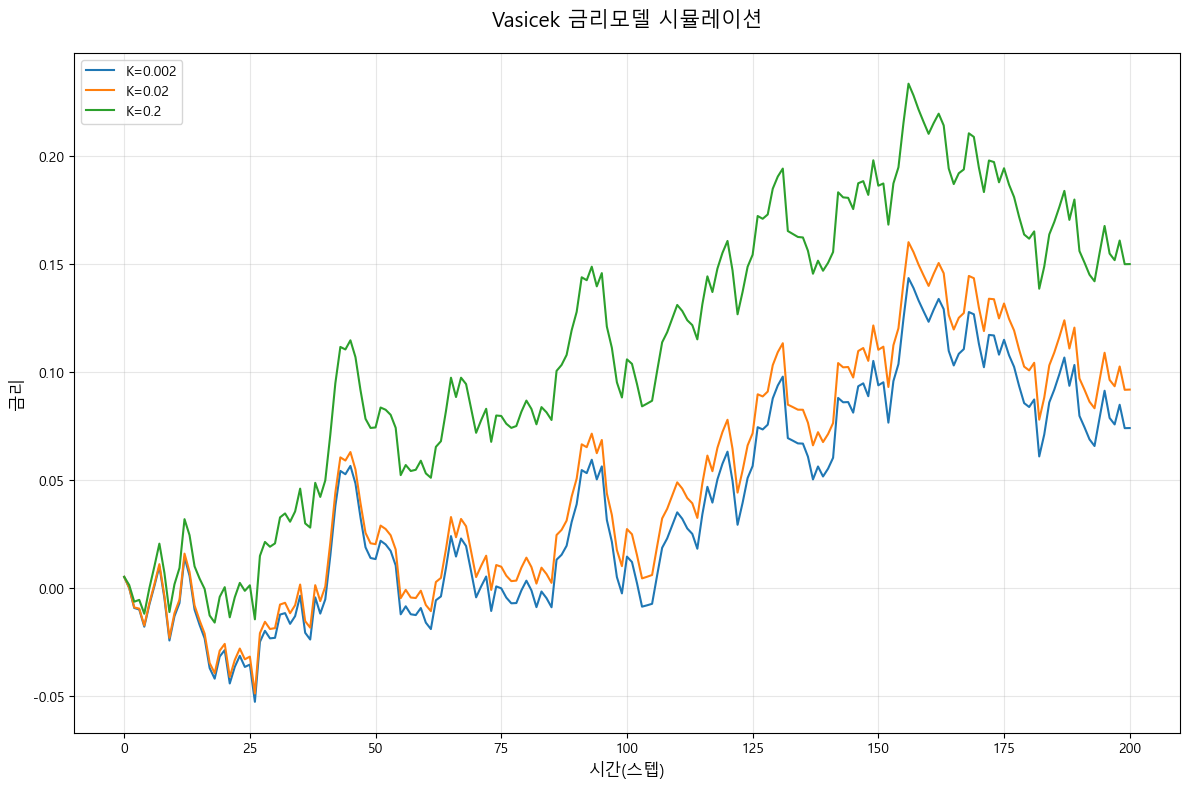

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt

def vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
    """
    Vasicek 금리모델 시뮬레이션 함수
    
    매개변수:
    r0 : float
        초기 금리
    K : float
        평균회귀 속도
    theta : float
        장기평균금리
    sigma : float
        변동성
    T : float
        시뮬레이션 기간 (년)
    N : int
        시뮬레이션 스텝 수
    seed : int
        난수 시드값
    
    반환값:
    tuple: (시간점들, 금리경로)
    """
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + \
            sigma*math.sqrt(dt)*np.random.normal()
        rates.append(rates[-1]+dr)
        
    return range(N+1), rates

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 8))

# 다양한 평균회귀 속도(K)에 대한 시뮬레이션
K_values = [0.002, 0.02, 0.2]
for K in K_values:
    x, y = vasicek(
        r0=0.005,      # 초기금리 0.5%
        K=K,           # 평균회귀 속도
        theta=0.15,    # 장기평균금리 15%
        sigma=0.05,    # 변동성 5%
        T=10,          # 10년
        N=200          # 200개 스텝
    )
    ax.plot(x, y, label=f'K={K}')

# 그래프 스타일링
ax.set_title('Vasicek 금리모델 시뮬레이션', fontsize=15, pad=20)
ax.set_xlabel('시간(스텝)', fontsize=12)
ax.set_ylabel('금리', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

## 콕스 인거졸 로스 모델

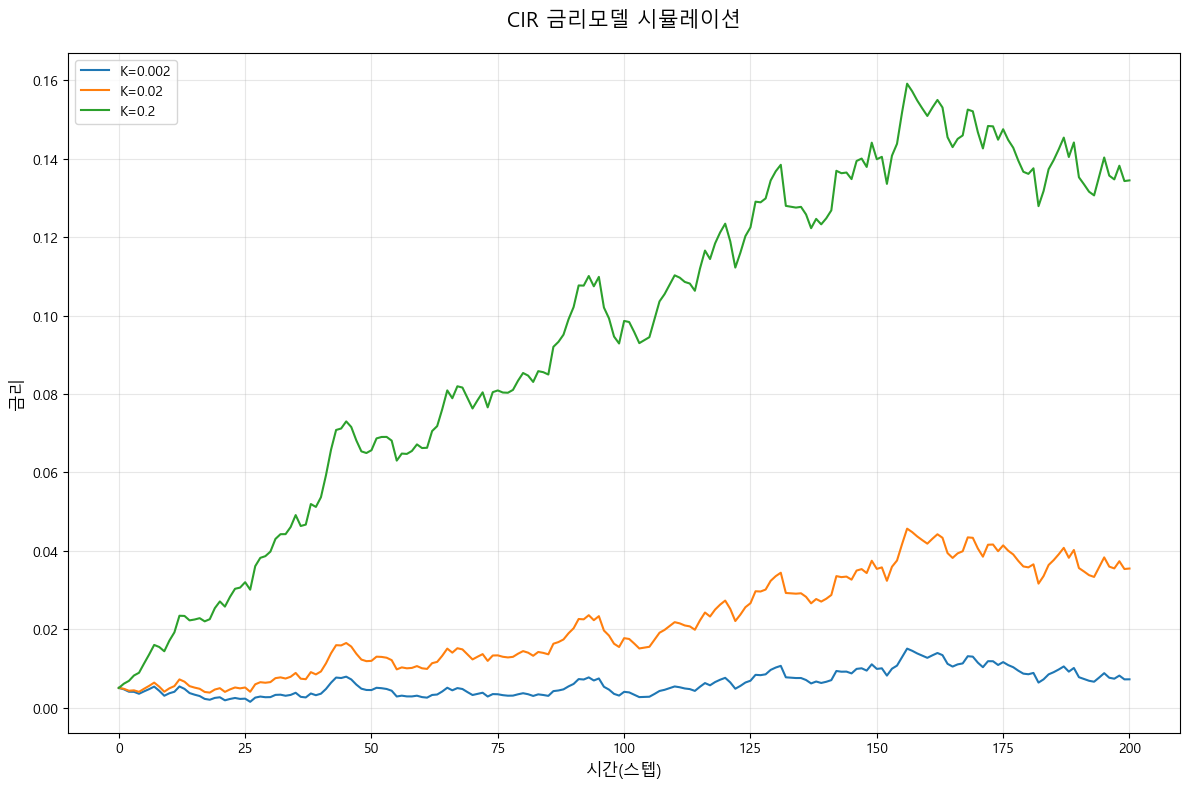

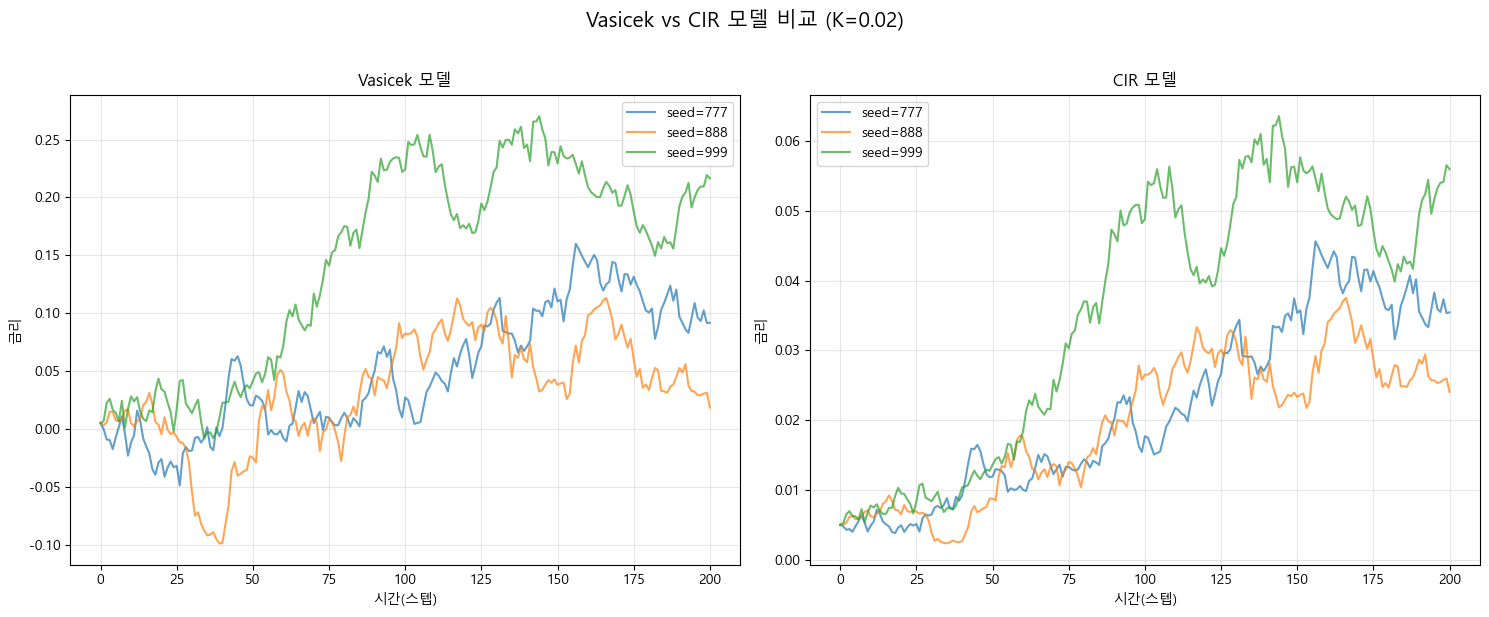

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt

def CIR(r0, K, theta, sigma, T=1., N=10, seed=777):
    """
    CIR(Cox-Ingersoll-Ross) 금리모델 시뮬레이션 함수
    dr = K(θ-r)dt + σ√r dW
    
    매개변수:
    r0 : float
        초기 금리
    K : float
        평균회귀 속도
    theta : float
        장기평균금리
    sigma : float
        변동성
    T : float
        시뮬레이션 기간 (년)
    N : int
        시뮬레이션 스텝 수
    seed : int
        난수 시드값
    
    반환값:
    tuple: (시간점들, 금리경로)
    """
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    
    for i in range(N):
        # CIR 모델: dr = K(θ-r)dt + σ√r dW
        dr = K*(theta-rates[-1])*dt + \
            sigma*math.sqrt(max(rates[-1], 0))*\
            math.sqrt(dt)*np.random.normal()
        rates.append(rates[-1] + dr)
        
    return range(N+1), rates

# 메인 그래프
fig, ax = plt.subplots(figsize=(12, 8))

# 다양한 평균회귀 속도(K)에 대한 시뮬레이션
K_values = [0.002, 0.02, 0.2]
for K in K_values:
    x, y = CIR(
        r0=0.005,      # 초기금리 0.5%
        K=K,           # 평균회귀 속도
        theta=0.15,    # 장기평균금리 15%
        sigma=0.05,    # 변동성 5%
        T=10,          # 10년
        N=200          # 200개 스텝
    )
    ax.plot(x, y, label=f'K={K}')

# 그래프 스타일링
ax.set_title('CIR 금리모델 시뮬레이션', fontsize=15, pad=20)
ax.set_xlabel('시간(스텝)', fontsize=12)
ax.set_ylabel('금리', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 여백 조정
plt.tight_layout()
plt.show()

# Vasicek vs CIR 비교
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 동일한 파라미터로 두 모델 비교
K = 0.02
for seed in [777, 888, 999]:
    # Vasicek 모델
    x, y_vas = vasicek(0.005, K, 0.15, 0.05, T=10, N=200, seed=seed)
    ax1.plot(x, y_vas, alpha=0.7, label=f'seed={seed}')
    
    # CIR 모델
    x, y_cir = CIR(0.005, K, 0.15, 0.05, T=10, N=200, seed=seed)
    ax2.plot(x, y_cir, alpha=0.7, label=f'seed={seed}')

# 그래프 스타일링
ax1.set_title('Vasicek 모델', fontsize=12)
ax1.set_xlabel('시간(스텝)')
ax1.set_ylabel('금리')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('CIR 모델', fontsize=12)
ax2.set_xlabel('시간(스텝)')
ax2.set_ylabel('금리')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Vasicek vs CIR 모델 비교 (K=0.02)', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

## 렌들만과 바터 모델

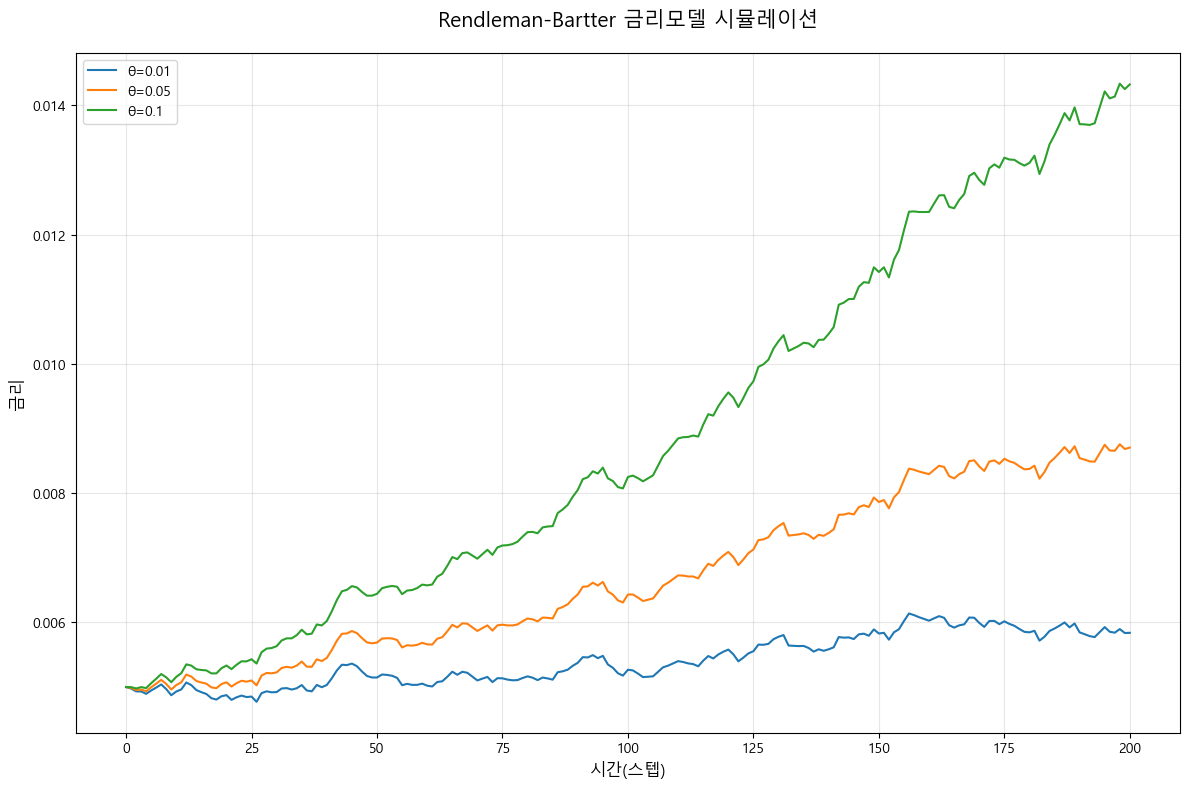

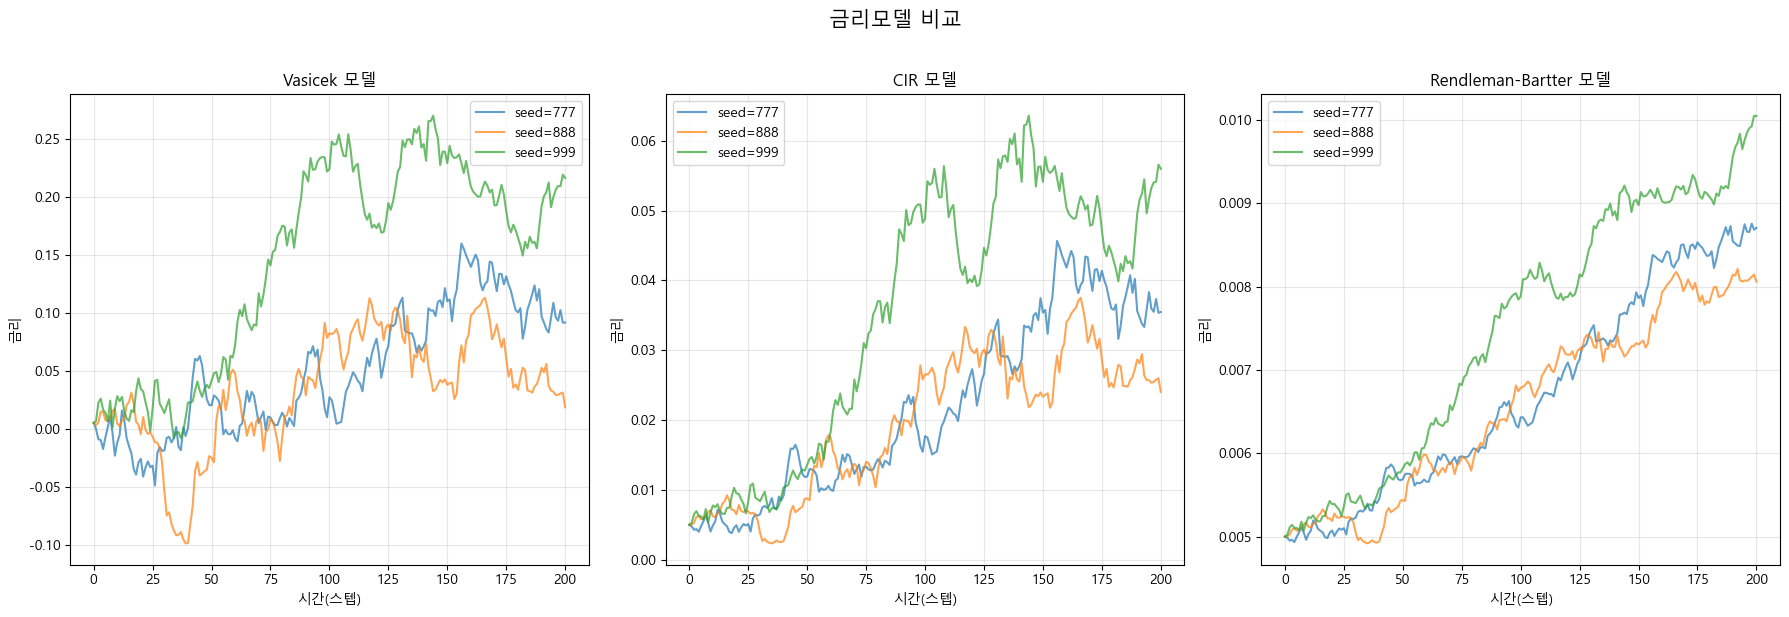

In [30]:
import math
import numpy as np
import matplotlib.pyplot as plt

def rendleman_bartter(r0, theta, sigma, T=1., N=10, seed=777):
    """
    Rendleman-Bartter 금리모델 시뮬레이션 함수
    dr = θrdt + σrdW
    
    매개변수:
    r0 : float
        초기 금리
    theta : float
        추세 계수
    sigma : float
        변동성 계수
    T : float
        시뮬레이션 기간 (년)
    N : int
        시뮬레이션 스텝 수
    seed : int
        난수 시드값
    
    반환값:
    tuple: (시간점들, 금리경로)
    """
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    
    for i in range(N):
        # Rendleman-Bartter 모델: dr = θrdt + σrdW
        dr = theta*rates[-1]*dt + \
            sigma*rates[-1]*math.sqrt(dt)*np.random.normal()
        rates.append(rates[-1] + dr)
        
    return range(N+1), rates

# 메인 그래프
fig, ax = plt.subplots(figsize=(12, 8))

# 다양한 추세 계수(theta)에 대한 시뮬레이션
theta_values = [0.01, 0.05, 0.1]
for theta in theta_values:
    x, y = rendleman_bartter(
        r0=0.005,      # 초기금리 0.5%
        theta=theta,   # 추세 계수
        sigma=0.05,    # 변동성 5%
        T=10,          # 10년
        N=200          # 200개 스텝
    )
    ax.plot(x, y, label=f'θ={theta}')

# 그래프 스타일링
ax.set_title('Rendleman-Bartter 금리모델 시뮬레이션', fontsize=15, pad=20)
ax.set_xlabel('시간(스텝)', fontsize=12)
ax.set_ylabel('금리', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 여백 조정
plt.tight_layout()
plt.show()

# 세 모델 비교 (Vasicek vs CIR vs Rendleman-Bartter)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 동일한 시드로 세 모델 비교
seeds = [777, 888, 999]
for seed in seeds:
    # Vasicek 모델
    x, y_vas = vasicek(0.005, 0.02, 0.15, 0.05, T=10, N=200, seed=seed)
    axes[0].plot(x, y_vas, alpha=0.7, label=f'seed={seed}')
    
    # CIR 모델
    x, y_cir = CIR(0.005, 0.02, 0.15, 0.05, T=10, N=200, seed=seed)
    axes[1].plot(x, y_cir, alpha=0.7, label=f'seed={seed}')
    
    # Rendleman-Bartter 모델
    x, y_rb = rendleman_bartter(0.005, 0.05, 0.05, T=10, N=200, seed=seed)
    axes[2].plot(x, y_rb, alpha=0.7, label=f'seed={seed}')

# 그래프 스타일링
titles = ['Vasicek 모델', 'CIR 모델', 'Rendleman-Bartter 모델']
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('시간(스텝)')
    ax.set_ylabel('금리')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('금리모델 비교', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

## 브레넨과 슈바르츠 모델

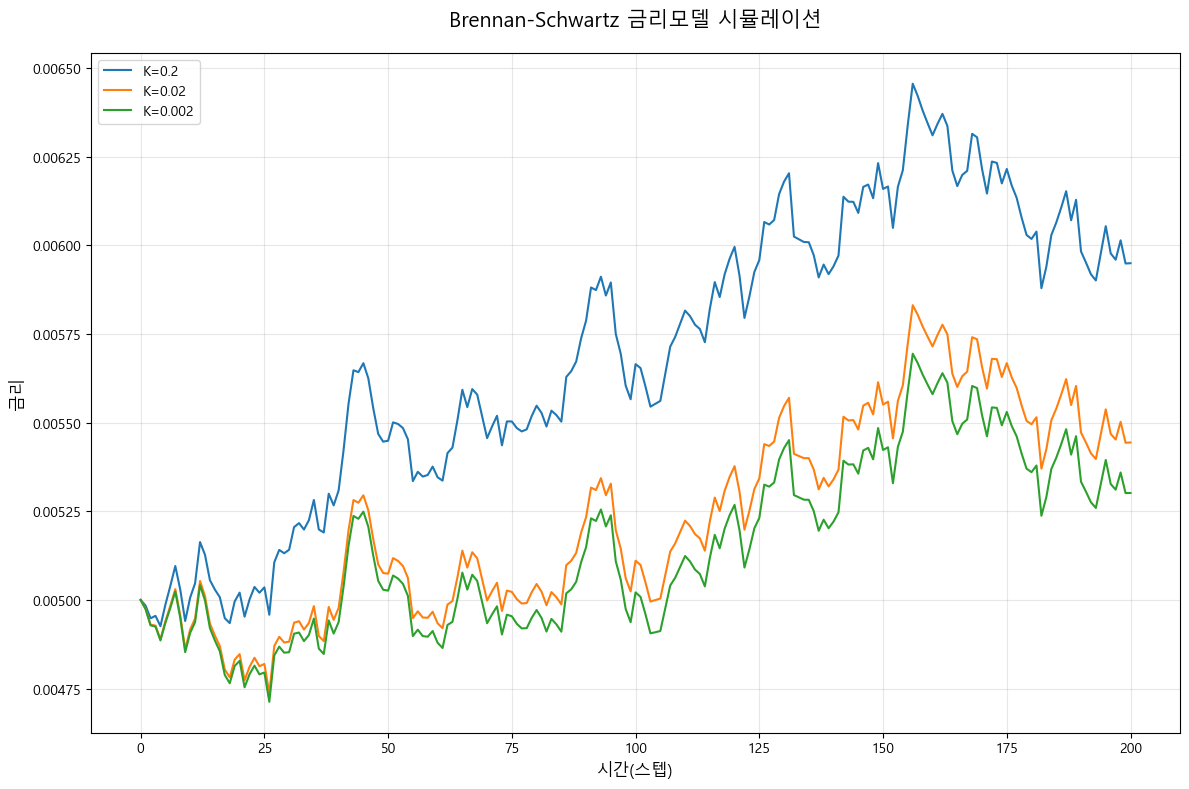

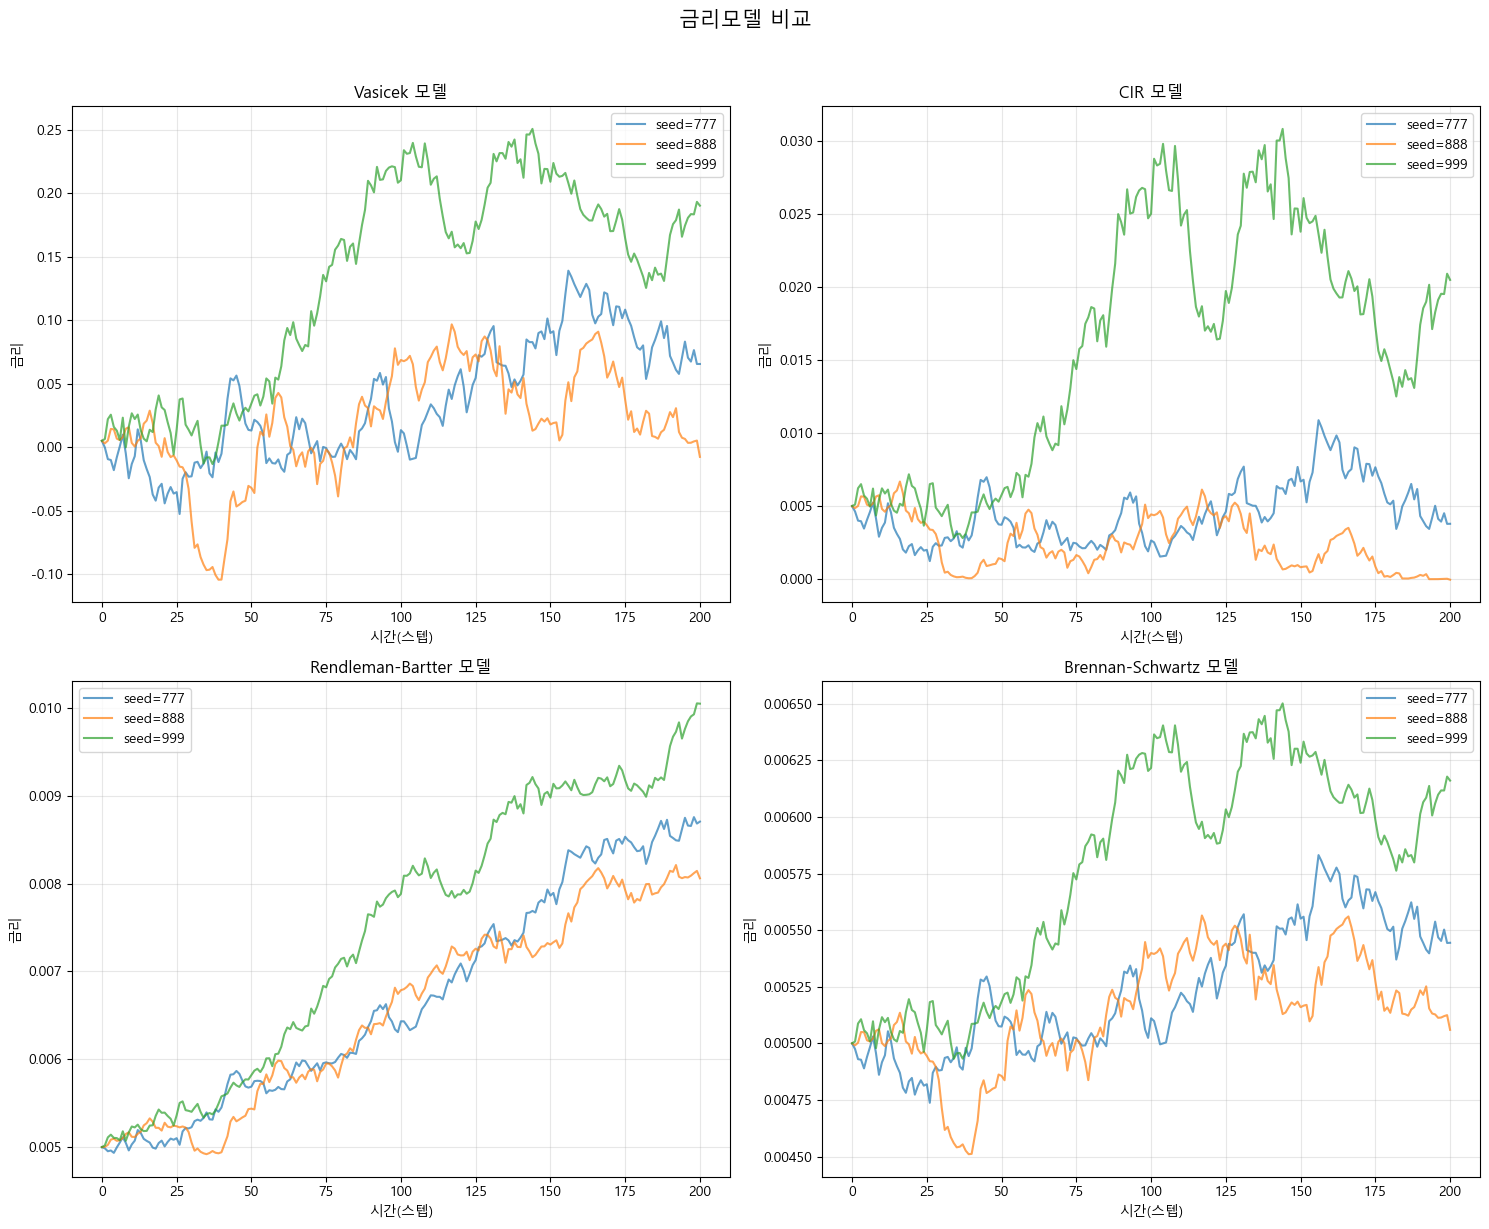

In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt

def brennan_schwartz(r0, K, theta, sigma, T=1., N=10, seed=777):
    """
    Brennan-Schwartz 금리모델 시뮬레이션 함수
    dr = K(θ-r)dt + σrdW
    
    매개변수:
    r0 : float
        초기 금리
    K : float
        평균회귀 속도
    theta : float
        장기평균금리
    sigma : float
        변동성 계수
    T : float
        시뮬레이션 기간 (년)
    N : int
        시뮬레이션 스텝 수
    seed : int
        난수 시드값
    
    반환값:
    tuple: (시간점들, 금리경로)
    """
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    
    for i in range(N):
        # Brennan-Schwartz 모델: dr = K(θ-r)dt + σrdW
        dr = K*(theta-rates[-1])*dt + \
            sigma*rates[-1]*math.sqrt(dt)*np.random.normal()
        rates.append(rates[-1] + dr)

    return range(N+1), rates

# 메인 그래프
fig, ax = plt.subplots(figsize=(12, 8))

# 다양한 평균회귀 속도(K)에 대한 시뮬레이션
K_values = [0.2, 0.02, 0.002]
for K in K_values:
    x, y = brennan_schwartz(
        r0=0.005,      # 초기금리 0.5%
        K=K,           # 평균회귀 속도
        theta=0.006,   # 장기평균금리 0.6%
        sigma=0.05,    # 변동성 5%
        T=10,          # 10년
        N=200          # 200개 스텝
    )
    ax.plot(x, y, label=f'K={K}')

# 그래프 스타일링
ax.set_title('Brennan-Schwartz 금리모델 시뮬레이션', fontsize=15, pad=20)
ax.set_xlabel('시간(스텝)', fontsize=12)
ax.set_ylabel('금리', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 여백 조정
plt.tight_layout()
plt.show()

# 모든 모델 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

models = [
    (vasicek, "Vasicek", 0.02),
    (CIR, "CIR", 0.02),
    (rendleman_bartter, "Rendleman-Bartter", 0.05),
    (brennan_schwartz, "Brennan-Schwartz", 0.02)
]

for idx, (model_func, title, param) in enumerate(models):
    for seed in [777, 888, 999]:
        if model_func == rendleman_bartter:
            x, y = model_func(0.005, param, 0.05, T=10, N=200, seed=seed)
        else:
            x, y = model_func(0.005, param, 0.006, 0.05, T=10, N=200, seed=seed)
        axes[idx].plot(x, y, alpha=0.7, label=f'seed={seed}')
    
    axes[idx].set_title(f'{title} 모델', fontsize=12)
    axes[idx].set_xlabel('시간(스텝)')
    axes[idx].set_ylabel('금리')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('금리모델 비교', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

# 채권옵션

## 바시첵 모델에 의한 제로쿠폰 채권 가격 책정

C:\Users\campus3S043\AppData\Local\Temp\ipykernel_4436\3754256966.py:79: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Malgun Gothic.
  plt.tight_layout()


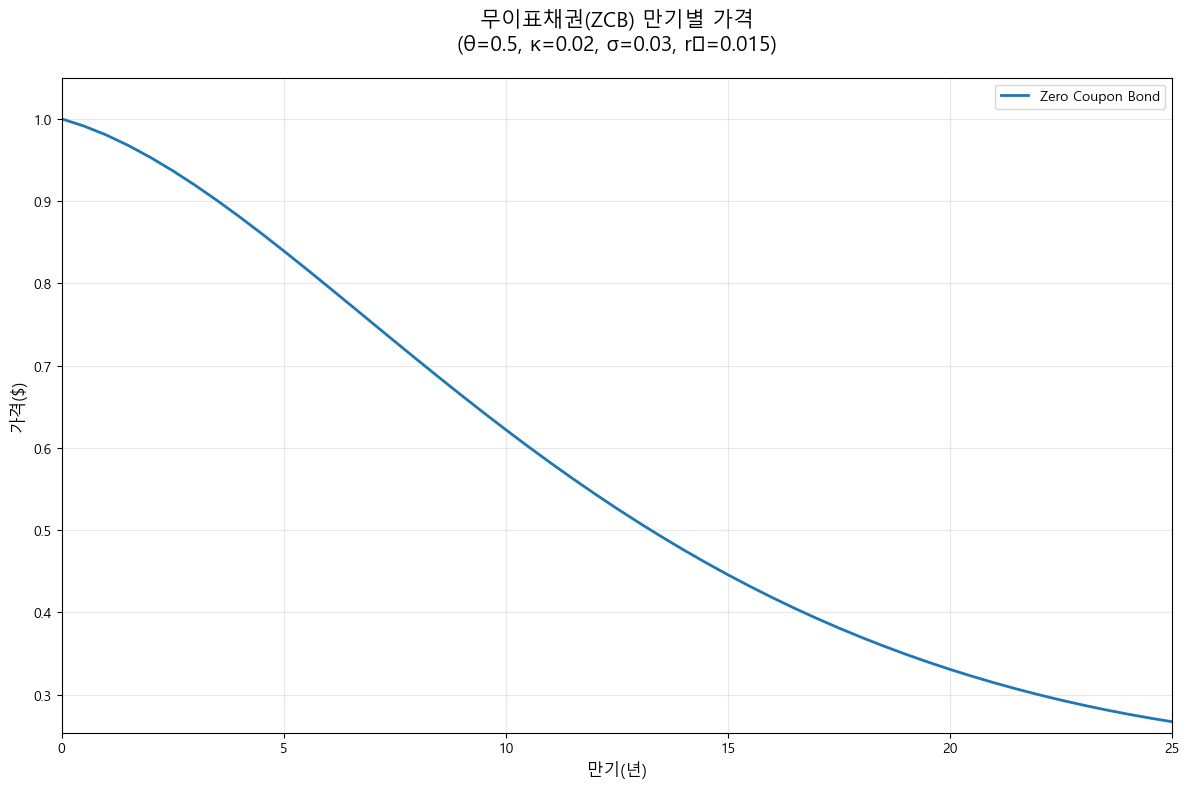


주요 만기별 무이표채권 가격:
----------------------------------------
     만기(년) |           가격($)
----------------------------------------
       0.5 |          0.9913
       1.0 |          0.9805
       2.0 |          0.9532
       5.0 |          0.8395
      10.0 |          0.6220
      20.0 |          0.3307


In [32]:
import numpy as np
import matplotlib.pyplot as plt

def exact_zcb(theta, kappa, sigma, tau, r0=0.):
    """
    Vasicek 모델 기반 무이표채권 가격 계산
    
    Parameters:
    -----------
    theta : float
        장기평균금리 (mean reversion level)
    kappa : float
        평균회귀속도 (mean reversion speed)
    sigma : float
        변동성 (volatility)
    tau : float
        잔존만기 (time to maturity)
    r0 : float, default=0.0
        현재금리 (current short rate)
    
    Returns:
    --------
    float
        무이표채권 가격
    """
    # 금리민감도 계산
    B = (1 - np.exp(-kappa*tau)) / kappa
    
    # 할인요소 계산
    A = np.exp(
        (theta - (sigma**2)/(2*(kappa**2))) * (B-tau) - \
        (sigma**2)/(4*kappa) * (B**2)
    )
    
    # 채권가격 = 할인요소 × exp(-현재금리 × 금리민감도)
    return A * np.exp(-r0*B)

# 시간 배열 생성 (0~25년, 0.5년 간격)
Ts = np.r_[0.0:25.5:0.5]

# 모델 파라미터 설정
PARAMS = {
    'theta': 0.5,    # 장기평균금리 50%
    'kappa': 0.02,   # 평균회귀속도 2%
    'sigma': 0.03,   # 변동성 3%
    'r0': 0.015      # 현재금리 1.5%
}

# 각 만기별 채권가격 계산
zcbs = [exact_zcb(
    theta=PARAMS['theta'],
    kappa=PARAMS['kappa'],
    sigma=PARAMS['sigma'],
    tau=t,
    r0=PARAMS['r0']
) for t in Ts]

# 그래프 설정
fig, ax = plt.subplots(figsize=(12, 8))

# 채권가격 곡선 플로팅
ax.plot(Ts, zcbs, label='Zero Coupon Bond', linewidth=2)

# 그래프 꾸미기
ax.set_title("무이표채권(ZCB) 만기별 가격\n" + \
            f"(θ={PARAMS['theta']}, κ={PARAMS['kappa']}, " + \
            f"σ={PARAMS['sigma']}, r₀={PARAMS['r0']})",
            fontsize=15, pad=20)
ax.set_xlabel("만기(년)", fontsize=12)
ax.set_ylabel("가격($)", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 축 범위 설정
ax.set_xlim(0, max(Ts))
ax.set_ylim(min(zcbs)*0.95, max(zcbs)*1.05)

# 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# 주요 만기별 가격 출력
key_maturities = [0.5, 1, 2, 5, 10, 20]
print("\n주요 만기별 무이표채권 가격:")
print("-" * 40)
print(f"{'만기(년)':>10} | {'가격($)':>15}")
print("-" * 40)
for t in key_maturities:
    idx = np.where(Ts == t)[0][0]
    print(f"{t:>10.1f} | {zcbs[idx]:>15.4f}")

## 조기 행사 가치

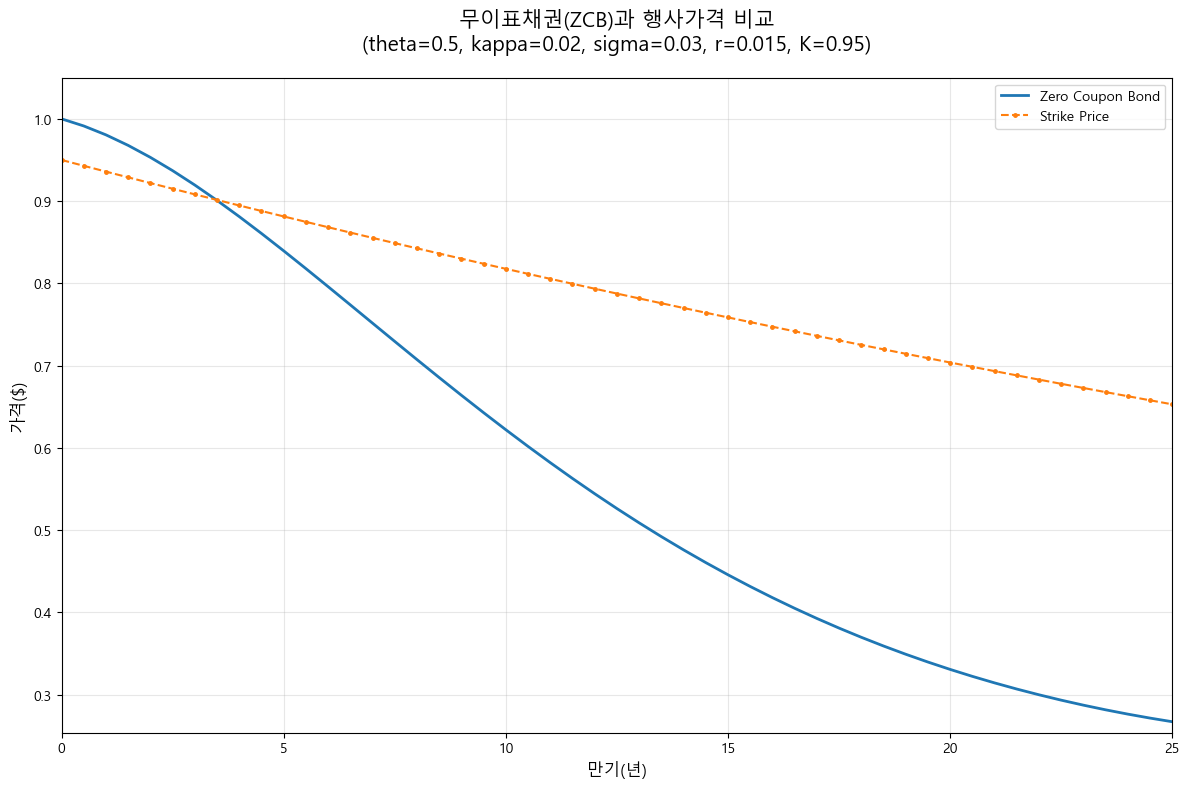


주요 만기별 가격 비교:
-----------------------------------------------------------------
     만기(년) |       ZCB 가격($) |         행사가격($) |           차이($)
-----------------------------------------------------------------
       0.5 |          0.9913 |          0.9429 |          0.0484
       1.0 |          0.9805 |          0.9359 |          0.0447
       2.0 |          0.9532 |          0.9219 |          0.0312
       5.0 |          0.8395 |          0.8814 |         -0.0418
      10.0 |          0.6220 |          0.8177 |         -0.1956
      20.0 |          0.3307 |          0.7038 |         -0.3731


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import math

def exercise_value(K, R, t):
    """
    채권 행사가치 계산 함수
    K * exp(-R*t)
    """
    return K * math.exp(-R*t)

# 시간 배열 생성 (0~25년, 0.5년 간격)
Ts = np.r_[0.0:25.5:0.5]

# 모델 파라미터
PARAMS = {
    'theta': 0.5,     # 장기평균금리
    'kappa': 0.02,    # 평균회귀속도
    'sigma': 0.03,    # 변동성
    'r0': 0.015,      # 현재금리
    'K': 0.95,        # 행사가격 (액면의 95%)
    'R': 0.015        # 할인율
}

# 각 만기별 가치 계산
Ks = [exercise_value(PARAMS['K'], PARAMS['R'], t) for t in Ts]
zcbs = [exact_zcb(
    PARAMS['theta'], 
    PARAMS['kappa'], 
    PARAMS['sigma'], 
    t, 
    PARAMS['r0']
) for t in Ts]

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 8))

# ZCB와 행사가격 곡선 플로팅
ax.plot(Ts, zcbs, label='Zero Coupon Bond', linewidth=2)
ax.plot(Ts, Ks, label='Strike Price', linestyle="--", marker=".", markersize=5)

# 그래프 스타일링
title = "무이표채권(ZCB)과 행사가격 비교\n" + \
        f"(theta={PARAMS['theta']}, kappa={PARAMS['kappa']}, " + \
        f"sigma={PARAMS['sigma']}, r={PARAMS['r0']}, K={PARAMS['K']})"
        
ax.set_title(title, fontsize=15, pad=20)
ax.set_xlabel("만기(년)", fontsize=12)
ax.set_ylabel("가격($)", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 축 범위 설정
ax.set_xlim(0, max(Ts))
ax.set_ylim(min(min(zcbs), min(Ks))*0.95, max(max(zcbs), max(Ks))*1.05)

# 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# 주요 만기별 가격 비교
key_maturities = [0.5, 1, 2, 5, 10, 20]
print("\n주요 만기별 가격 비교:")
print("-" * 65)
print(f"{'만기(년)':>10} | {'ZCB 가격($)':>15} | {'행사가격($)':>15} | {'차이($)':>15}")
print("-" * 65)
for t in key_maturities:
    idx = np.where(Ts == t)[0][0]
    diff = zcbs[idx] - Ks[idx]
    print(f"{t:>10.1f} | {zcbs[idx]:>15.4f} | {Ks[idx]:>15.4f} | {diff:>15.4f}")

## 유한 차이에 의한 정책 반복

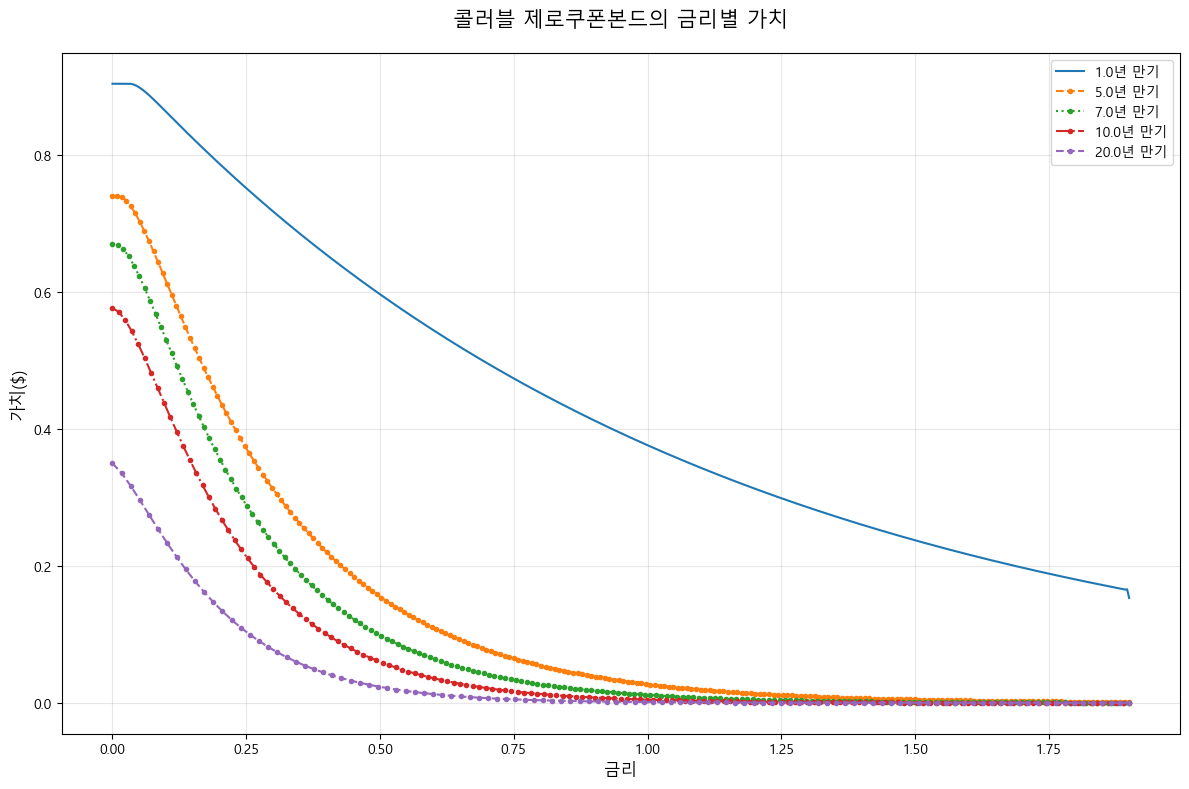

In [35]:
import math
import numpy as np
import scipy.stats as st

class VasicekCZCB:
    """
    Vasicek 모델을 사용한 콜러블 제로쿠폰본드(Callable Zero Coupon Bond) 가치평가 클래스
    
    주요 기능:
    - Vasicek 금리모형 기반 채권가치 계산
    - 유한차분법을 통한 수치해 도출
    - 조기상환옵션 가치 반영
    - 다양한 만기의 채권가치 비교

    주요 메서드:
    - vasicek_czcb_values(): 채권가치 계산
    - vasicek_params(): 모델 파라미터 설정
    - vasicek_limits(): 금리 상하한 계산
    - iterate(): 반복계산을 통한 수렴값 도출
    
    Attributes:
        norminv: 정규분포 역함수
        norm: 정규분포 누적확률함수
    """
    
    def __init__(self):
        """
        클래스 초기화
        정규분포 관련 함수 설정
        """
        self.norminv = st.distributions.norm.ppf
        self.norm = st.distributions.norm.cdf        

    def vasicek_czcb_values(self, r0, R, ratio, T, sigma, kappa, theta,
                            M, prob=1e-6, max_policy_iter=10, 
                            grid_struct_const=0.25, rs=None):
        """
        Vasicek 모델 기반 콜러블 제로쿠폰본드 가치 계산
        
        Parameters:
        -----------
        r0 : float
            초기금리
        R : float
            무위험이자율
        ratio : float
            행사가격 비율
        T : float
            만기
        sigma : float
            변동성
        kappa : float
            평균회귀속도
        theta : float
            장기평균금리
        M : int
            시간분할 수
        prob : float
            신뢰구간 확률
        max_policy_iter : int
            최대 반복횟수
        grid_struct_const : float
            격자 구조 상수
        rs : array
            금리 범위
            
        Returns:
        --------
        tuple: (금리배열, 가치배열)
        """
        (r_min, dr, N, dtau) = \
            self.vasicek_params(r0, M, sigma, kappa, theta,
                                T, prob, grid_struct_const, rs)
        r = np.r_[0:N]*dr + r_min
        v_mplus1 = np.ones(N)

        for i in range(1, M+1):
            K = self.exercise_call_price(R, ratio, i*dtau)
            eex = np.ones(N)*K
            (subdiagonal, diagonal, superdiagonal) = \
                self.vasicek_diagonals(
                    sigma, kappa, theta, r_min, dr, N, dtau)
            (v_mplus1, iterations) = \
                self.iterate(subdiagonal, diagonal, superdiagonal,
                             v_mplus1, eex, max_policy_iter)
        return r, v_mplus1

    def vasicek_params(self, r0, M, sigma, kappa, theta, T,
                      prob, grid_struct_const=0.25, rs=None):
        """
        Vasicek 모델 파라미터 계산
        
        Returns:
        --------
        tuple: (최소금리, 금리간격, 격자수, 시간간격)
        """
        if rs is not None:
            (r_min, r_max) = (rs[0], rs[-1])
        else:
            (r_min, r_max) = self.vasicek_limits(
                r0, sigma, kappa, theta, T, prob)        

        dt = T/float(M)
        N = self.calculate_N(grid_struct_const, dt, sigma, r_max, r_min)
        dr = (r_max-r_min)/(N-1)

        return (r_min, dr, N, dt)
    
    def calculate_N(self, max_structure_const, dt, sigma, r_max, r_min):
        """
        격자 크기 N 계산
        """
        N = 0
        while True:
            N += 1
            grid_structure_interval = \
                dt*(sigma**2)/(((r_max-r_min)/float(N))**2)
            if grid_structure_interval > max_structure_const:
                break
        return N
    
    def vasicek_limits(self, r0, sigma, kappa, theta, T, prob=1e-6):
        """
        Vasicek 모델의 금리 상하한 계산
        
        Returns:
        --------
        tuple: (최소금리, 최대금리)
        """
        er = theta+(r0-theta)*math.exp(-kappa*T)
        variance = (sigma**2)*T if kappa==0 else \
                    (sigma**2)/(2*kappa)*(1-math.exp(-2*kappa*T))
        stdev = math.sqrt(variance)
        r_min = self.norminv(prob, er, stdev)
        r_max = self.norminv(1-prob, er, stdev)
        return (r_min, r_max)

    def vasicek_diagonals(self, sigma, kappa, theta, r_min,
                          dr, N, dtau):
        """
        Vasicek 모델의 삼중대각행렬 계산
        """
        rn = np.r_[0:N]*dr + r_min
        subdiagonals = kappa*(theta-rn)*dtau/(2*dr) - \
                        0.5*(sigma**2)*dtau/(dr**2)
        diagonals = 1 + rn*dtau + sigma**2*dtau/(dr**2)
        superdiagonals = -kappa*(theta-rn)*dtau/(2*dr) - \
                        0.5*(sigma**2)*dtau/(dr**2)

        # 경계조건 구현
        if N > 0:
            v_subd0 = subdiagonals[0]
            superdiagonals[0] = superdiagonals[0]-subdiagonals[0]
            diagonals[0] += 2*v_subd0
            subdiagonals[0] = 0

        if N > 1:
            v_superd_last = superdiagonals[-1]
            superdiagonals[-1] = superdiagonals[-1] - subdiagonals[-1]
            diagonals[-1] += 2*v_superd_last
            superdiagonals[-1] = 0

        return (subdiagonals, diagonals, superdiagonals)
    
    def check_exercise(self, V, eex):
        """
        조기상환 조건 확인
        """
        return V > eex

    def exercise_call_price(self, R, ratio, tau):
        """
        콜옵션 행사가격 계산
        """
        K = ratio*np.exp(-R*tau)
        return K

    def vasicek_policy_diagonals(self, subdiagonal, diagonal, \
                                 superdiagonal, v_old, v_new, eex):
        """
        정책반복을 위한 대각행렬 갱신
        """
        has_early_exercise = self.check_exercise(v_new, eex)
        subdiagonal[has_early_exercise] = 0
        superdiagonal[has_early_exercise] = 0
        policy = v_old/eex
        policy_values = policy[has_early_exercise]
        diagonal[has_early_exercise] = policy_values
        return (subdiagonal, diagonal, superdiagonal)

    def iterate(self, subdiagonal, diagonal, superdiagonal,
                v_old, eex, max_policy_iter=10):
        """
        반복계산을 통한 수렴값 도출
        
        Parameters:
        -----------
        subdiagonal : array
            하부대각행렬
        diagonal : array
            주대각행렬
        superdiagonal : array
            상부대각행렬
        v_old : array
            이전 가치
        eex : array
            행사가치
        max_policy_iter : int
            최대 반복횟수
            
        Returns:
        --------
        tuple: (수렴된 가치, 반복횟수)
        """
        v_mplus1 = v_old
        v_m = v_old
        change = np.zeros(len(v_old))
        prev_changes = np.zeros(len(v_old))

        iterations = 0
        while iterations <= max_policy_iter:
            iterations += 1

            v_mplus1 = self.tridiagonal_solve(
                    subdiagonal, diagonal, superdiagonal, v_old)
            subdiagonal, diagonal, superdiagonal = \
                self.vasicek_policy_diagonals(
                    subdiagonal, diagonal, superdiagonal, 
                    v_old, v_mplus1, eex)

            is_eex = self.check_exercise(v_mplus1, eex)
            change[is_eex] = 1

            if iterations > 1:
                change[v_mplus1 != v_m] = 1

            is_no_more_eex = False if True in is_eex else True
            if is_no_more_eex:
                break

            v_mplus1[is_eex] = eex[is_eex]
            changes = (change == prev_changes)

            is_no_further_changes = all((x == 1) for x in changes)
            if is_no_further_changes:
                break

            prev_changes = change
            v_m = v_mplus1

        return v_mplus1, iterations-1

    def tridiagonal_solve(self, a, b, c, d):
        """
        삼중대각행렬 방정식 해결
        Thomas 알고리즘 사용
        """
        nf = len(a)  # 방정식 수
        ac, bc, cc, dc = map(np.array, (a, b, c, d))  # 배열 복사
        for it in range(1, nf):
            mc = ac[it]/bc[it-1]
            bc[it] = bc[it] - mc*cc[it-1] 
            dc[it] = dc[it] - mc*dc[it-1]

        xc = ac
        xc[-1] = dc[-1]/bc[-1]

        for il in range(nf-2, -1, -1):
            xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

        del bc, cc, dc  # 메모리에서 변수 삭제

        return xc

# 파라미터 설정
r0 = 0.05      # 초기 금리
R = 0.05       # 무위험 이자율
ratio = 0.95   # 행사가격 비율
sigma = 0.03   # 변동성
kappa = 0.15   # 평균회귀속도
theta = 0.05   # 장기평균금리
prob = 1e-6    # 신뢰구간 확률
M = 250        # 시간 분할 수
max_policy_iter = 10  # 최대 반복횟수
grid_struct_interval = 0.25  # 격자 구조 간격
rs = np.r_[0.0:2.0:0.1]  # 금리 범위

# 클래스 인스턴스 생성
vasicek = VasicekCZCB()

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 8))

# 다양한 만기에 대한 가치 계산 및 플로팅
maturities = [1., 5., 7., 10., 20.]
styles = ['-', '--', ':', '-.', '--']

for T, style in zip(maturities, styles):
    r, vals = vasicek.vasicek_czcb_values(
        r0, R, ratio, T, sigma, kappa, theta, 
        M, prob, max_policy_iter, grid_struct_interval, rs)
    ax.plot(r, vals, 
            label=f'{T}년 만기', 
            linestyle=style,
            marker='.' if T > 1 else None)

# 그래프 스타일링
ax.set_title("콜러블 제로쿠폰본드의 금리별 가치", fontsize=15, pad=20)
ax.set_xlabel("금리", fontsize=12)
ax.set_ylabel("가치($)", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()